# Running SCORE on a few examples

In this Notebook we are going to run SCORE on a few radio image examples.

## Required Libraries and Functions

In [1]:
%matplotlib inline
import sys

# Add library path to PYTHONPATH
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_meerkat_64/'

# Libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import pickle
from score import score
import starlets

# Function
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def starlet_op(signal):
    n_scale = 4
    bool_gen = True
    return starlets.star2d(signal,scale=n_scale,gen2=bool_gen)

def estimate_thresholds(im,psf):
    """This method estimates the standard deviation map of propagated 
    normalised noise in the starlet space.
    INPUT: None
    OUTPUT: std_map, 3D Numpy Array"""
    psf_rot = cl.rotate180(psf)
    sigma = cl.sigma_mad(im)
    def noise_op(res):
        """This function backprojects the noise to the image space.
        INPUT: res, 2D Numpy Array
        OUTPUT: bp_res, 2D Numpy Array"""
        res = sigma*cl.convolve(res,psf,'same')
        bp_res = np.array(cl.comp_grad(res,psu,mu,gamma))
        bp_res = cl.convolve(bp_res,psf_rot,'same')
        return bp_res
    noise = np.random.randn(n_maps,n_row,n_col)
    #noise backprojection
    bp_noise = np.array([noise_op(n) for n in noise])
    #Starlet transforms of noise
    starlet_noise = np.array([starlet_op(bn) for bn in bp_noise])
    #estimate the noise standard deviation condering every noise
    #realisation for every pixel in every scale
    sigma_map = np.array([[[np.std(y) for y in pos] for pos in scale] \
                             for scale in np.moveaxis(starlet_noise,0,-1)])
    thresholds = np.vstack(([(k+1)*s for s in sigma_map[:1]],\
                                     [k*s for s in sigma_map[1:]]))
    return thresholds

## Load the Evaluation Dataset

In [2]:
f = open(data_path+"meerkat_batch.pkl", "rb")
batch = pickle.load(f)
f.close()

## Extract Batches and Concatenate Them

In [3]:
batch.keys()
n_batch, Nx, Ny = batch['targets'].shape

## Plot Galaxy Images

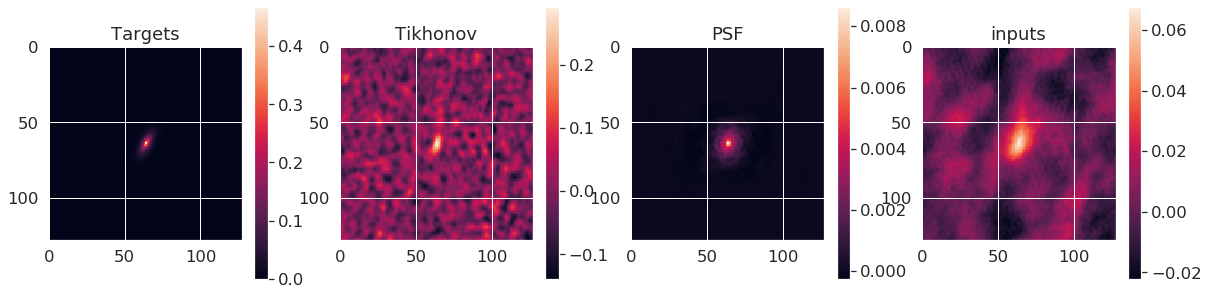

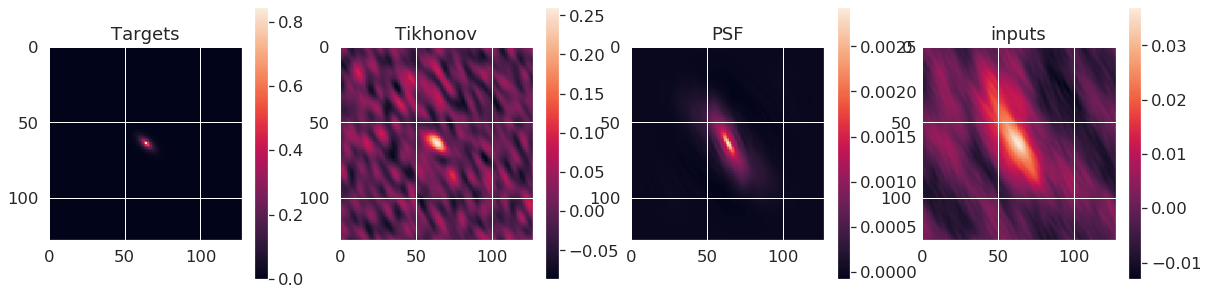

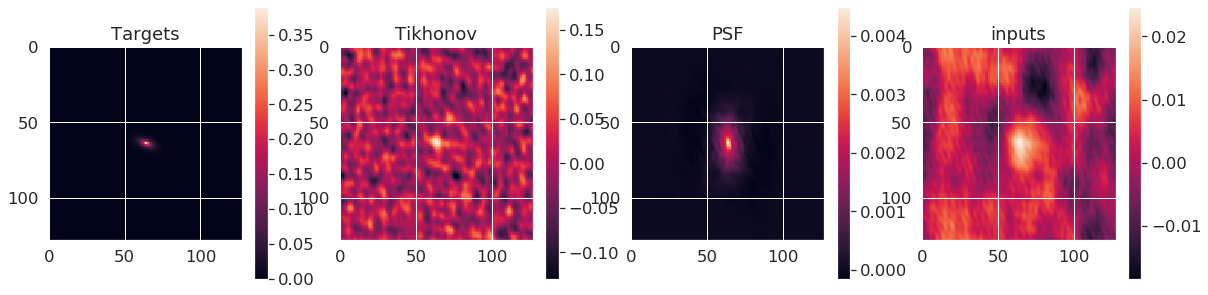

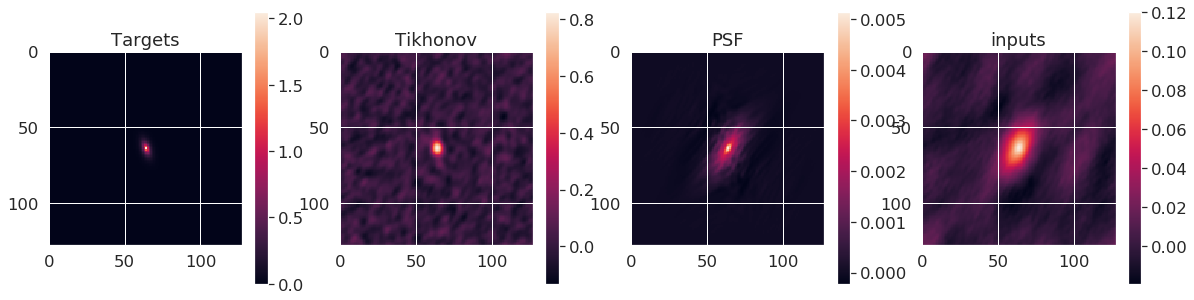

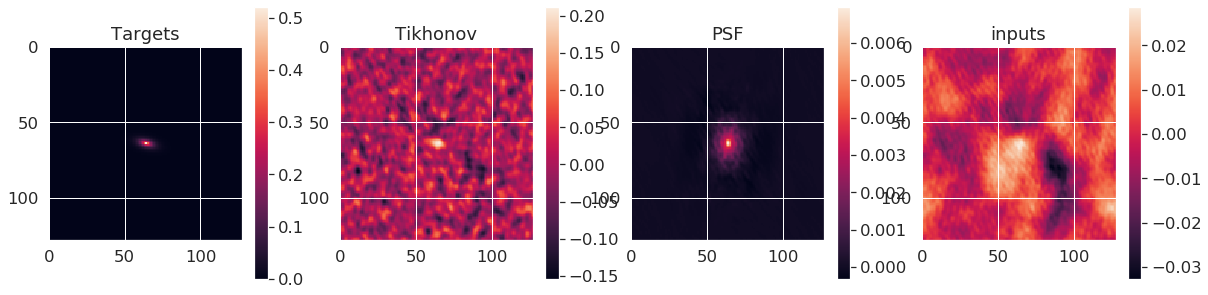

In [4]:
# set seaborn theme and style
sns.set_theme()
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

for i in range(5):#n_batch):
    plt.figure(33,figsize=(20,5))
    plt.subplot(141)
    plt.imshow(batch['targets'][i])
    plt.title('Targets')
    plt.colorbar()
    plt.subplot(142)
    plt.imshow(batch['inputs_tikho'][i])
    plt.title('Tikhonov')
    plt.colorbar()
    plt.subplot(143)
    plt.imshow(batch['psf'][i])
    plt.title('PSF')
    plt.colorbar()
    plt.subplot(144)
    plt.imshow(batch['inputs'][i])
    plt.title('inputs')
    plt.colorbar()
    plt.show()

## Load and Apply Trained Model on Batch

In [ ]:
# SET SCORE PARAMETERS

gamma = 0
n_row = batch['inputs'].shape[-2]
n_col = batch['inputs'].shape[-1]
n_shearlet = 3
n_maps = 100

U = cl.makeUi(n_row,n_col)
_,shearlets_adj = cl.get_shearlets(n_row
                                   ,n_col
                                   ,n_shearlet)
#Adjoint shealret transform of U, i.e Psi^{Star}(U)
psu = np.array([cl.convolve_stack(ui,shearlets_adj) for ui in U])
mu = cl.comp_mu(psu)

In [13]:
# LOAD IMAGES AND PSF

n_batch = batch['psf'].shape[0]
# generate the psfs in the spatial domain
shape = batch['inputs'].shape[-1]

gal_num = 5
gals_obs = [batch['inputs'][gal_num]]
psfs = [batch['psf'][gal_num]]

# Initiate instance of score
# set the value of gamma
g1 = score(gamma=gamma,rip=False,verbose=False)

# Run SCORE

k = 6
#loop
sol_g1 = []
i=1
for obs, psf in zip(gals_obs,psfs):
    #compute thresholds
    thresholds = estimate_thresholds(obs,psf)
    #deconvolve
    g1.deconvolve(obs=obs,psf=psf,thresholds=thresholds)
    sol_g1 += [g1.solution]
    if i%10 == 0:
        print(i)
    i += 1

# filename = data_path + 'score_g1'
# np.save(filename,np.array(sol_g1))

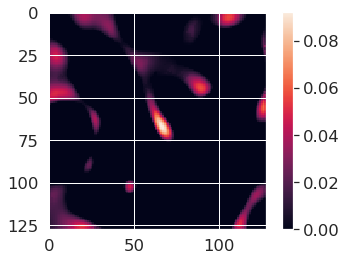

In [14]:
plt.imshow(sol_g1[0]);plt.colorbar()

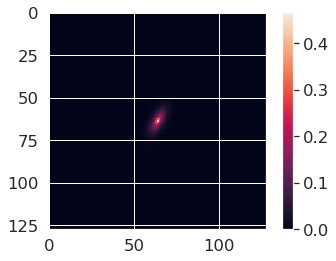

In [15]:
plt.imshow(batch['targets'][0]);plt.colorbar()

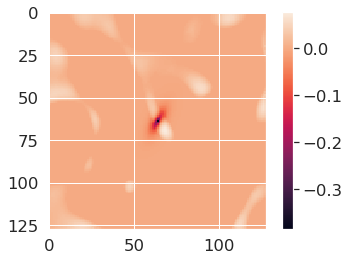

In [16]:
plt.imshow(sol_g1[0]-batch['targets'][0]);plt.colorbar()

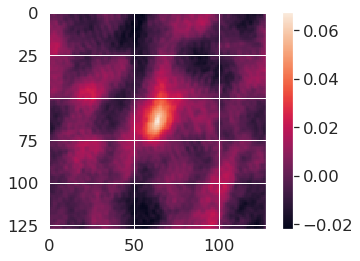

In [12]:
plt.imshow(batch['inputs'][0]);plt.colorbar()